# Solving knapsack problem with OpenQAOA

In [25]:
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt

#import problem classes from OQ for easy problem creation
from openqaoa.problems import Knapsack


#import the QAOA workflow model
from openqaoa import QAOA

#import method to specify the device
from openqaoa.backends import create_device

## Create random knapsack instance

In [266]:

knapsack_prob = Knapsack.random_instance(n_items=4,seed=30)
knapsack_qubo = knapsack_prob.qubo

print('cost hamiltonian:')
knapsack_qubo.hamiltonian.expression

cost hamiltonian:


-10.5Z_{4} - 11.0Z_{5} - 11.5Z_{2} - 12.0Z_{1} - 5.5Z_{3} - 6.0Z_{0} + 12.0Z_{1}Z_{2} + 12.0Z_{1}Z_{4} + 12.0Z_{1}Z_{5} + 12.0Z_{2}Z_{4} + 12.0Z_{2}Z_{5} + 12.0Z_{4}Z_{5} + 29.5 + 3.0Z_{0}Z_{3} + 6.0Z_{0}Z_{1} + 6.0Z_{0}Z_{2} + 6.0Z_{0}Z_{4} + 6.0Z_{0}Z_{5} + 6.0Z_{1}Z_{3} + 6.0Z_{2}Z_{3} + 6.0Z_{3}Z_{4} + 6.0Z_{3}Z_{5}

In [267]:
knapsack_qubo.asdict()

{'terms': [[0, 1],
  [2, 3],
  [2, 4],
  [2, 5],
  [3, 4],
  [3, 5],
  [4, 5],
  [0, 2],
  [0, 3],
  [0, 4],
  [0, 5],
  [1, 2],
  [1, 3],
  [1, 4],
  [1, 5],
  [0],
  [1],
  [2],
  [3],
  [4],
  [5]],
 'weights': [6.0,
  6.0,
  12.0,
  12.0,
  6.0,
  6.0,
  12.0,
  6.0,
  3.0,
  6.0,
  6.0,
  12.0,
  6.0,
  12.0,
  12.0,
  -6.0,
  -12.0,
  -11.5,
  -5.5,
  -10.5,
  -11.0],
 'constant': 29.5,
 'n': 6,
 'problem_instance': {'problem_type': 'knapsack',
  'values': [1, 1, 3, 2],
  'weights': [2, 1, 2, 2],
  'weight_capacity': 4,
  'penalty': 6,
  'n_items': 4},
 'metadata': {}}

 ## Extract exact solution for a small enogh problem

https://augustineaykara.github.io/Knapsack-Calculator/

In [268]:
import numpy as np

hamiltonian = knapsack_qubo.hamiltonian

# import the brute-force solver to obtain exact solution
from openqaoa.utilities import ground_state_hamiltonian
energy, configuration = ground_state_hamiltonian(hamiltonian)
print(f"Ground State energy: {energy}, Solution: {configuration}")

item_values = np.array(knapsack_qubo.problem_instance.get("values"))
item_weights = np.array(knapsack_qubo.problem_instance.get("weights"))
solution = list(map(int, list(configuration[0][-4:])))

print('max. profit:',np.inner(item_values,solution))
print('total weight:',np.inner(item_weights,solution))

Ground State energy: -5.0, Solution: ['000011']
max. profit: 5
total weight: 4


## Build the QAOA model

In [269]:
# initialize model with default configurations
q = QAOA()

# device
qiskit_device = create_device(location='local', name='qiskit.statevector_simulator')
q.set_device(qiskit_device)

# circuit properties
q.set_circuit_properties(p=7, param_type='standard', init_type='rand', mixer_hamiltonian='x')

# backend properties (already set by default)
q.set_backend_properties(prepend_state=None, append_state=None)

# classical optimizer properties
q.set_classical_optimizer(method='cobyla', tol=0.001,maxiter=100,
                          optimization_progress=True, cost_progress=True, parameter_log=True)

In [270]:
q.compile(knapsack_qubo)

In [271]:
q.optimize()

## Accessing the results

Most probable states: ['001100']
[1, 1, 0, 0]
max. profit: 2
weight: 3
states kept: 40


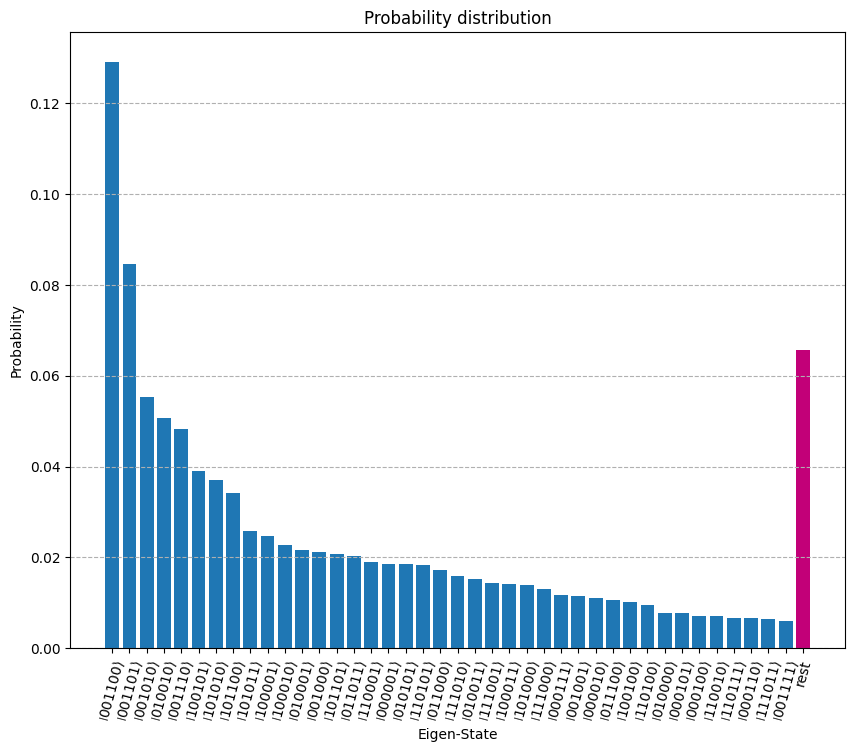

In [273]:
opt_results = q.result

print('Most probable states:',opt_results.most_probable_states['solutions_bitstrings'])

item_values = np.array(knapsack_qubo.problem_instance.get("values"))
item_weights = np.array(knapsack_qubo.problem_instance.get("weights"))
solution = opt_results.most_probable_states['solutions_bitstrings'][0]
solution = list(map(int, list(solution[-4:])))
print(solution)

print('max. profit:',np.inner(item_values,solution))
print('weight:',np.inner(item_weights,solution))

opt_results.plot_probabilities()